---
title: High-dimensional Regression -- Ridge and LASSO
---

We illustrate regularization in high-dimensional regression in the context of a simple high-dimensional linear regression model that is applicable to the CA population dataset. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

Here is the CA population dataset from FRED.

  observation_date   CAPOP
0       1900-01-01  1490.0
1       1901-01-01  1550.0
2       1902-01-01  1623.0
3       1903-01-01  1702.0
4       1904-01-01  1792.0
5       1905-01-01  1893.0
6       1906-01-01  1976.0
7       1907-01-01  2054.0
8       1908-01-01  2161.0
9       1909-01-01  2282.0
    observation_date      CAPOP
115       2015-01-01  38904.296
116       2016-01-01  39149.186
117       2017-01-01  39337.785
118       2018-01-01  39437.463
119       2019-01-01  39437.610
120       2020-01-01  39521.958
121       2021-01-01  39142.565
122       2022-01-01  39142.414
123       2023-01-01  39198.693
124       2024-01-01  39431.263


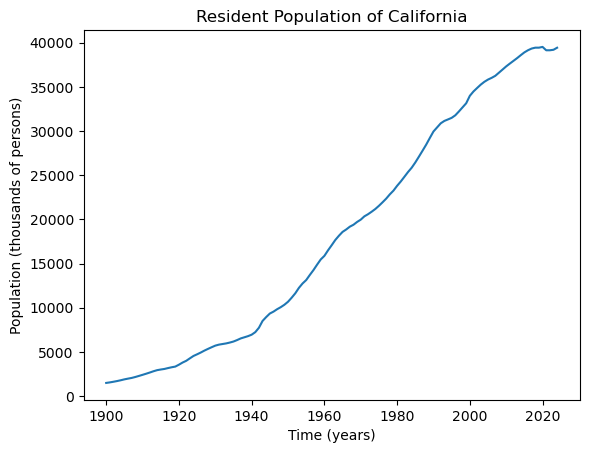

In [36]:
capop = pd.read_csv('CAPOP-Feb2025FRED.csv')
print(capop.head(10))
print(capop.tail(10))
tme = np.arange(1900, 2025)
plt.plot(tme, capop['CAPOP'])
plt.xlabel("Time (years)")
plt.ylabel('Population (thousands of persons)')
plt.title("Resident Population of California")
plt.show()

It is better to fit regression models to the logarithm of the population for better interpretability. 

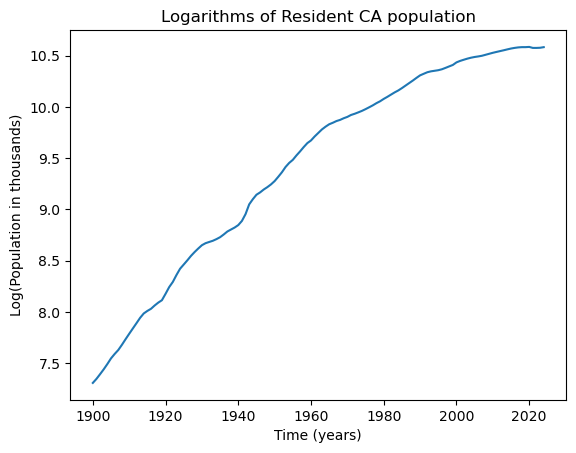

In [37]:
y = np.log(capop['CAPOP'])
n = len(y)
plt.plot(tme, y)
plt.xlabel("Time (years)")
plt.ylabel('Log(Population in thousands)')
plt.title("Logarithms of Resident CA population")
plt.show()

The model we consider is:
\begin{equation*}
  y_t = \beta_0 + \beta_1 (t - 1) + \beta_2 (t - 2)_+ + \beta_3 (t - 3)_+ + \dots + \beta_{n-1} (t - (n-1))_+ + \epsilon_t
\end{equation*}
We can write this as
\begin{equation*}
   y = X_{\text{full}} \beta + \epsilon
\end{equation*}
where $X_{\text{full}}$ is constructed as below. 

In [40]:
n = len(y)
x = np.arange(1, n+1)
Xfull = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    Xfull = np.column_stack([Xfull, xc])
print(Xfull)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 122. 121. ...   1.   0.  -0.]
 [  1. 123. 122. ...   2.   1.   0.]
 [  1. 124. 123. ...   3.   2.   1.]]


If we fit this model without any regularization, we get the following. 

In [41]:
mdfull = sm.OLS(y, Xfull).fit()
print(mdfull.summary())

                            OLS Regression Results                            
Dep. Variable:                  CAPOP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 20 Feb 2025   Prob (F-statistic):                nan
Time:                        16:27:38   Log-Likelihood:                 3312.0
No. Observations:                 125   AIC:                            -6374.
Df Residuals:                       0   BIC:                            -6020.
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3065        inf          0        n

/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


As discussed in class, in this unregularized estimation, the estimate of $\beta_0$ equals $y_1$, the estimate of $\beta_1$ is $y_2 - y_1$, and the estimate of $\beta_j$ is $y_{j+1} - 2 y_j + y_{j-1}$ for $j = 2, \dots, n-1$. Let us check this. 

In [44]:
print(y[0])
print(y[1] - y[0])
print(y[2] - y[1] - y[1] + y[0])

7.306531398939505
0.03947881097378758
0.006542546627510859


We now compute the ridge and lasso regularized estimators using the optimization library cvxpy. 

In [71]:
import cvxpy as cp

Here is the function for solving the ridge optimization function.  

In [72]:
def solve_ridge(X, y, lambda_val, penalty_start=2):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value


Below is the code for computing the ridge estimator. Play around with different values of $\lambda$ and see how the estimator changes. 

In [73]:
b_ridge = solve_ridge(Xfull, y, lambda_val = 100000)
print(b_ridge)

[ 7.40992500e+00  4.00275320e-02 -1.03393598e-06 -3.10729516e-06
 -6.16012894e-06 -1.01173938e-05 -1.48639792e-05 -2.02516508e-05
 -2.62512136e-05 -3.28752427e-05 -4.00153757e-05 -4.75259297e-05
 -5.52764995e-05 -6.31470039e-05 -7.10198428e-05 -7.87699738e-05
 -8.63654917e-05 -9.39528806e-05 -1.01719569e-04 -1.09738889e-04
 -1.18120654e-04 -1.27023211e-04 -1.36213007e-04 -1.45423138e-04
 -1.54537869e-04 -1.63267866e-04 -1.71382635e-04 -1.78857604e-04
 -1.85662158e-04 -1.91743221e-04 -1.97103040e-04 -2.01773603e-04
 -2.05808616e-04 -2.09384087e-04 -2.12750427e-04 -2.16159037e-04
 -2.19814220e-04 -2.23891485e-04 -2.28486860e-04 -2.33668768e-04
 -2.39599808e-04 -2.46442465e-04 -2.54308514e-04 -2.63142884e-04
 -2.72627130e-04 -2.82155494e-04 -2.91566429e-04 -3.00762399e-04
 -3.09851859e-04 -3.18886155e-04 -3.27961902e-04 -3.37138098e-04
 -3.46414491e-04 -3.55691964e-04 -3.64846907e-04 -3.73676401e-04
 -3.82093673e-04 -3.90105211e-04 -3.97580623e-04 -4.04423834e-04
 -4.10505946e-04 -4.15729

Below we plot the fitted values corresponding to the ridge estimator.

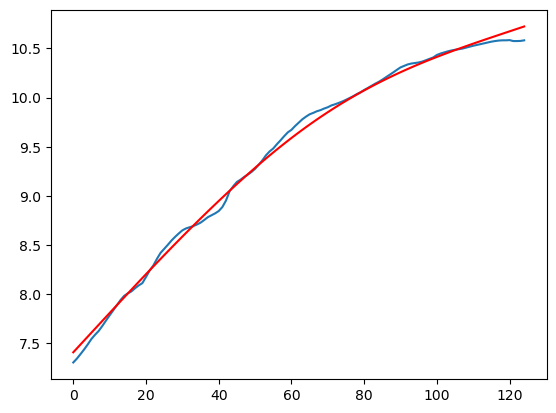

In [74]:
plt.plot(y)
ridge_fitted = np.dot(Xfull, b_ridge)
plt.plot(ridge_fitted, color = 'red')
plt.show()

Here is the function for minimizing the LASSO objective function.

In [75]:
def solve_lasso(X, y, lambda_val, penalty_start=2):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.norm1(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value


Below we compute the LASSO estimator. Play around with different values of $\lambda$ to see how the estimator changes. 

In [76]:
b_lasso = solve_lasso(Xfull, y, lambda_val = .01)
print(b_lasso)

[ 7.30269244e+00  4.59956784e-02  1.13278408e-08  1.92462120e-03
 -6.40268980e-08 -8.76035991e-08 -3.26952149e-04  2.39052977e-07
  3.15904351e-07  4.25073456e-03 -8.28996771e-07 -1.43863686e-06
 -1.38512978e-06 -7.25660808e-07 -1.18645663e-02 -1.28015230e-02
  2.50450783e-06  4.92198082e-06  5.37794880e-06  3.39542374e-06
  3.32017284e-02 -2.85923941e-06 -4.18132818e-06 -3.62826460e-06
 -1.78335862e-06 -1.72912123e-02 -8.43883921e-04 -4.69975439e-11
 -4.33949820e-03 -3.51071562e-03 -2.36868613e-03 -1.62391659e-02
 -7.05713503e-04  2.49825628e-11  4.86634719e-11  5.48622386e-03
  2.67797948e-03  4.60402492e-07  8.60595266e-07  8.60883578e-07
  4.60848871e-07  1.59946901e-02  3.65403551e-02  1.86624170e-11
 -1.57150031e-02 -1.93457918e-02 -1.43745192e-02  2.65602870e-09
  4.10959590e-09  2.66020735e-09  5.39348565e-03  1.19154305e-02
 -4.84872664e-12 -4.77326914e-12 -2.72354092e-03 -1.71136426e-03
 -2.64531238e-08 -4.09115505e-08 -2.65104251e-08 -1.67071216e-03
 -3.64020007e-03 -1.73333

The LASSO estimator is typically sparse. This can be checked by the code below where we only display the estimated coefficients which cross a threshold in absolute value. 

In [77]:
threshold = 1e-6
significant_idx = np.where(np.abs(b_lasso) > threshold)[0]
print(b_lasso[significant_idx])
# Or to see index-value pairs:
for idx in significant_idx:
    print(f"Index {idx}: {b_lasso[idx]}")

[ 7.30269244e+00  4.59956784e-02  1.92462120e-03 -3.26952149e-04
  4.25073456e-03 -1.43863686e-06 -1.38512978e-06 -1.18645663e-02
 -1.28015230e-02  2.50450783e-06  4.92198082e-06  5.37794880e-06
  3.39542374e-06  3.32017284e-02 -2.85923941e-06 -4.18132818e-06
 -3.62826460e-06 -1.78335862e-06 -1.72912123e-02 -8.43883921e-04
 -4.33949820e-03 -3.51071562e-03 -2.36868613e-03 -1.62391659e-02
 -7.05713503e-04  5.48622386e-03  2.67797948e-03  1.59946901e-02
  3.65403551e-02 -1.57150031e-02 -1.93457918e-02 -1.43745192e-02
  5.39348565e-03  1.19154305e-02 -2.72354092e-03 -1.71136426e-03
 -1.67071216e-03 -3.64020007e-03 -6.10737429e-03 -4.40160149e-03
 -8.63951229e-03 -1.34388452e-05 -3.06913086e-05 -4.38085884e-05
 -4.82612296e-05 -4.35525458e-05 -3.23813391e-05 -1.89046354e-05
 -7.09617760e-06  1.44915200e-03  2.34048430e-03  8.38154364e-04
  1.22310692e-03 -1.03101380e-05  5.58349511e-04  5.77659149e-05
  1.03355846e-04  1.00494541e-04  5.27519904e-05  1.36670616e-03
  1.76617276e-03  1.54282

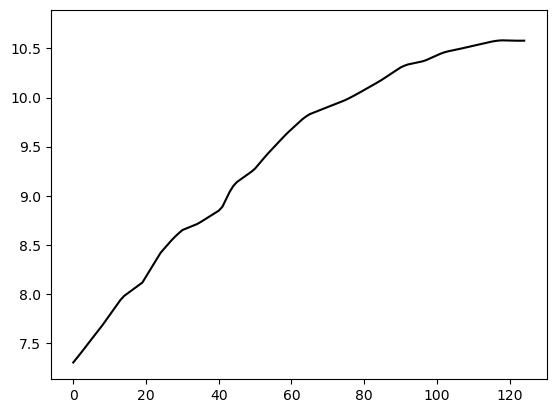

In [78]:
plt.plot(y, color = 'None')
ridge_fitted = np.dot(Xfull, b_ridge)
plt.plot(ridge_fitted, color = 'None')
lasso_fitted = np.dot(Xfull, b_lasso)
plt.plot(lasso_fitted, color = 'black')
plt.show()